# R5.C.08 - Analyse de données : ACP, AFC

## 1. Codesource, fichier(s) de données ou un lien de récupération


Le code source et le jeu de données sont disponibles sur GitHub :
- [https://github.com/Arcthuruss/Glue-factory-analysis](https://github.com/Arcthuruss/Glue-factory-analysis)
**Instruction** : Git LFS est requis pour cloner le dépôt car le jeu de données est volumineux (=448Mo).

---

## 2. Introduction, constitution du groupe

Le projet consiste à analyser un jeu de données de notre choix en utilisant des techniques d'analyse de données vues lors de la ressource R5.C.08 - Techniques d'intelligence artificielle.
Avec pour objectif de pratiquer les techniques d'ACP (Analyse en Composantes Principales) et d'AFC (Analyse Factorielle des Correspondances) sur des variables quantitatives et qualitatives respectivement.

Le projet a été réalisé par un groupe de deux personnes :
- DONNARD Luc
- NÉVOT Pierre

---

## 3. Description du jeu de données

Le jeu de données provient de Kaggle : [https://www.kaggle.com/datasets/takamotoki/jra-horse-racing-dataset](https://www.kaggle.com/datasets/takamotoki/jra-horse-racing-dataset)

Il contient plusieurs csv tel que :
- 19860105-20210731_laptime.csv qui contient les données des tours de chaque course entre 1986 et 2021
- 19860105-20210731_odds.csv qui contient les cotes des chevaux pour chaque course entre 1986 et 2021
- 19860105-20210731_race_results.csv qui contient les résultats de chaque course entre 1986 et 2021
- 20020615-20210731_corner_passing_order.csv qui contient les positions des chevaux à chaque virage entre 2002 et 2021

On a choisi d'utiliser 19860105-20210731_race_results.csv car il contient des informations sur le resultat du cheval gagnant ainsi que pleins d'informations sur la course.
Le dataset contient au minimun 1 554 146 entrées et 66 colonnes au total.

En voici les principales variables :
- Turf and Dirt Category : Catégorie de la piste (herbe ou terre)
- Clockwise And Anti-clockwise and Straight Course Category : Catégorie de la course (sens horaire, antihoraire ou ligne droite)
- Distance(m) : Distance de la course en mètres
- Weather : Conditions météorologiques
- Track Condition1 : État de la piste
- Final Position : Position finale du cheval
- Bracket Number : Numéro de la série
- Post Position : Position de départ
- Horse Name : Nom du cheval
- Age : Âge du cheval
- Jockey : Nom du jockey
- Total Time(1/10s) : Temps total en dixièmes de seconde
- Position 3rd Corner : Position au 3ème virage
- Position 4th Corner : Position au 4ème virage
- Win Odds(100Yen) : Cote de victoire (en 100 Yen)
- Win Fav : Favori à la victoire

Le contexte est l'analyse des courses de chevaux au Japon, en utilisant des données historiques pour identifier des tendances et des facteurs influençant les résultats des courses.

---

## 4. Nettoyage de données

On a retiré les colonnes non pertinentes qui contenaient des valeurs non pertinentes et incomplètes.
On a ensuite traduit les attributs importants du japonais vers l'anglais pour faciliter l'analyse.
Tel que le type de course, si la course est dans le sens des aiguilles d'une montre ou non, la météo, l'état de la piste.
A part cela le dataset étant propre on a 1 554 146 entrées de données complètes.

In [3]:
# imports du projet
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from biplot import *

time_str_to_ms = lambda time_as_str : np.array([(int(i[0])*600 + int(i[1])*10 + int(i[2])) for i in [i.replace(':', ' ').replace('.', ' ').split(' ') for i in time_as_str]])

In [10]:
# filter script

input_file = "./datasets/19860105-20210731_race_result.csv"
output_file = "./clean_datasets/filtered_race_result.csv"

# Ligne qui va être supprimée (pas de nom de colonne car le header est en japonais et prendrais trop de temps)
positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 40, 41, 43, 47, 49, 52, 53, 54, 57, 60, 61, 62, 63, 64, 65]

with open(input_file, newline='', encoding='utf-8') as infile, \
    open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    for row in reader:
        filtered_row = [col for i, col in enumerate(row) if i not in positions]
        if all(filtered_row):
            writer.writerow(filtered_row)

# Remplace le header par le header en anglais
with open(output_file, 'r', newline='', encoding='utf-8') as infile:
    lines = infile.readlines()
header = "Turf and Dirt Category,Clockwise And Anti-clockwise and Straight Course Category,Distance(m),Weather,Track Condition1,Final Position,Bracket Number,Post Position,Horse Name,Age,Jockey,Total Time(1/10s),Position 3rd Corner,Position 4th Corner,Win Odds(100Yen),Win Fav"
lines[0] = header + "\n"
with open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    outfile.writelines(lines)


In [11]:
# Traduit les noms propres jopnais en anglais

# Fonction pour charger le cache
def load_cache(cache_file):
    try:
        with open(cache_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

# Fonction pour sauvegarder le cache
def save_cache(cache, cache_file):
    with open(cache_file, 'w', encoding='utf-8') as f:
        json.dump(cache, f, ensure_ascii=False, indent=4)

# Si la valeur n'est pas dans le cache, demande la traduction
def ask_translation(text):
    print(f"Traduction pour '{text}': ", end="")
    return input().strip()

def annotate_csv(input_file, output_file, cache_file='translation_cache.json'):
    cache = load_cache(cache_file)
    df = pd.read_csv(input_file)

    # Ne traiter que les 5 premières colonnes
    cols_to_check = df.columns[:5]

    for col in cols_to_check:
        for i, value in enumerate(df[col]):
            if pd.isna(value):
                continue
            # Vérifier si la valeur est du texte japonais et non déjà dans le cache
            if value not in cache and any('\u3040' <= char <= '\u30ff' or '\u4e00' <= char <= '\u9faf' for char in str(value)):
                translation = ask_translation(value)
                cache[value] = translation

    save_cache(cache, cache_file)

def replace_with_cache(df, cache):
    for col in df.columns[:5]:
        df[col] = df[col].apply(lambda x: cache.get(x, x) if pd.notna(x) else x)
    return df

input_file = "./clean_datasets/filtered_race_result.csv"
output_file = "./clean_datasets/translated_race_result.csv"
annotate_csv(input_file, output_file)
cache = load_cache('translation_cache.json')
df = pd.read_csv(input_file)
df = replace_with_cache(df, cache)
df.to_csv(output_file, index=False)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1150145917.py, line 29)

---

## 5. Variables quantitatives : ACP

### 5.1 Standardisation












In [4]:
translated_file = "./clean_datasets/translated_race_result.csv"
df = pd.read_csv(translated_file)

In [5]:
distance = df.iloc[:, 2].values
final_position = df.iloc[:, 5].values
bracket_number = df.iloc[:, 6].values
post_position = df.iloc[:, 7].values
age = df.iloc[:, 9].values
third_corner_position = df.iloc[:, 12].values
fourth_corner_position = df.iloc[:, 13].values
win_odds = df.iloc[:, 14].values
win_fav = df.iloc[:, 15].values
time = time_str_to_ms(df.iloc[:, 11].values)

values = np.stack(
    (
        distance,
        final_position,
        bracket_number,
        post_position,
        age,
        third_corner_position,
        fourth_corner_position,
        win_odds,
        win_fav,
        time
    ),
    axis=1
)

scaler = StandardScaler()
scaler.fit(values)
values_scaled = scaler.transform(values)
# values_scaled = values

### 5.2 Entraînement du modèle

Effectuez une ACP (Analyse en Composantes Principales) sur les données standardisées.

In [6]:
# pca = PCA(n_components=2)
pca = PCA()
pca_res = pca.fit_transform(values_scaled)



### 5.3 Choix du nombre de composantes principales

Expliquez le critère de choix (ex : seuil de variance expliquée).

### 5.4 Tableau de valeurs singulières + % variance

Présentez un tableau avec les valeurs propres et le pourcentage de variance expliquée par chaque composante.

  Dimension  Valeur propre  % valeur propre  % cum. val. prop.
0      Dim1       3.107968             31.0               31.0
1      Dim2       2.015908             20.0               51.0
2      Dim3       1.896916             19.0               70.0
3      Dim4       1.059175             11.0               81.0
4      Dim5       0.976950             10.0               91.0
5      Dim6       0.541653              5.0               96.0
6      Dim7       0.248068              2.0               98.0
7      Dim8       0.087880              1.0               99.0
8      Dim9       0.056935              1.0              100.0
9     Dim10       0.008554              0.0              100.0


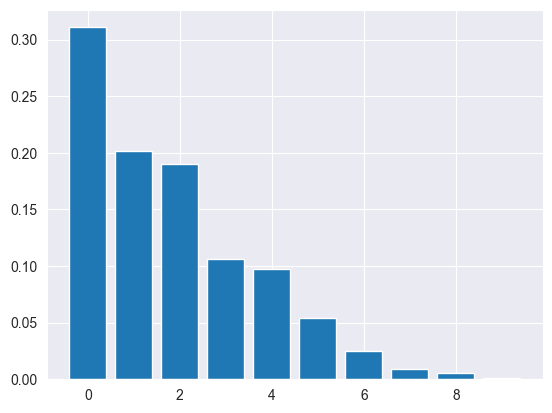

In [7]:
eig = pd.DataFrame ({
    "Dimension" :
        ["Dim" + str ( x + 1 ) for x in range (10)],
    "Valeur propre" : pca.explained_variance_,
    "% valeur propre" :
        np.round (pca.explained_variance_ratio_ * 100),
    "% cum. val. prop." :
        np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
})
print(eig)

y1 = list(pca.explained_variance_ratio_)
x1 = range(len(y1))
plt.bar(x1, y1)
plt.show()

### 5.5 Visualisation des variables avec biplot, étude sur la corrélation entre variables

Affichez un biplot et commentez la corrélation entre variables.

In [ ]:
from scipy.spatial import ConvexHull
import numpy as np
from sklearn.decomposition import PCA
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm

def biplot(pca=[],x=None,y=None,components=[0,1],score=None,\
           coeff=None,coeff_labels=None,score_labels=None,circle='T',\
           bigdata=1000,cat=None,cmap="viridis",density=True):
    if isinstance(pca,PCA)==True :
        coeff = np.transpose(pca.components_[components, :])
        score=  pca.fit_transform(x)[:,components]
        if isinstance(x,pd.DataFrame)==True :
            coeff_labels = list(x.columns)
    if score is not None : x = score
    if x.shape[1]>1 :
        xs = x[:,0]
        ys = x[:,1]
    else :
        xs = x
        ys = y
    if (len(xs) != len(ys)) : print("Warning ! x et y n'ont pas la même taille !")
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    #x_c = xs * scalex
    #y_c = ys * scaley
    temp = (xs - xs.min())
    x_c = temp / temp.max() * 2 - 1
    temp = (ys - ys.min())
    y_c = temp / temp.max() * 2 - 1
    data = pd.DataFrame({"x_c":x_c,"y_c":y_c})
    print("Attention : pour des facilités d'affichage, les données sont centrées-réduites")
    if cat is None : cat = [0]*len(xs)
    elif len(pd.Series(cat)) == 1 : cat = list(pd.Series(cat))*len(xs)
    elif len(pd.Series(cat)) != len(xs) : print("Warning ! Nombre anormal de catégories !")
    cat = pd.Series(cat).astype("category")
    fig = plt.figure(figsize=(6,6),facecolor='w')
    ax = fig.add_subplot(111)
    # Affichage des points
    if (len(xs) < bigdata) :
        ax.scatter(x_c,y_c, c = cat.cat.codes,cmap=cmap)
        if density==True : print("Warning ! Le mode density actif n'apparait que si BigData est paramétré.")
    # Affichage des nappes convexes (BigData)
    else :
        #color
        norm = mpl.colors.Normalize(vmin=0, vmax=(len(np.unique(cat.cat.codes)))) #-(len(np.unique(c)))
        cmap = cmap
        m = cm.ScalarMappable(norm=norm, cmap=cmap)
        if density==True :
            sns.set_style("white")
            sns.kdeplot(x="x_c",y="y_c",data=data)
            if len(np.unique(cat)) <= 1 :
                sns.kdeplot(x="x_c",y="y_c",data=data, cmap="Blues", shade=True, thresh= 0)
            else :
                for i in np.unique(cat) :
                    color_temp = m.to_rgba(i)
                    sns.kdeplot(x="x_c",y="y_c",data=data[cat==i], color=color_temp,
                                shade=True, thresh=0.25, alpha=0.25)
        for cat_temp in cat.cat.codes.unique() :
            x_c_temp = [x_c[i] for i in range(len(x_c)) if (cat.cat.codes[i] == cat_temp)]
            y_c_temp = [y_c[i] for i in range(len(y_c)) if (cat.cat.codes[i] == cat_temp)]
            points = [ [ None ] * len(x_c_temp) ] * 2
            points = np.array(points)
            points = points.reshape(len(x_c_temp),2)
            points[:,0] = x_c_temp
            points[:,1] = y_c_temp
            hull = ConvexHull(points)
            temp = 0
            for simplex in hull.simplices:
                color_temp = m.to_rgba(cat_temp)
                plt.plot(points[simplex, 0], points[simplex, 1],color=color_temp)
                if (temp == 0) :
                     plt.xlim(-1,1)
                     plt.ylim(-1,1)
                     temp = temp+1
    if coeff is not None :
        if (circle == 'T'):
            x_circle = np.linspace(-1, 1, 100)
            y_circle = np.linspace(-1, 1, 100)
            X, Y = np.meshgrid(x_circle,y_circle)
            F = X**2 + Y**2 - 1.0
            #fig, ax = plt.subplots()
            plt.contour(X,Y,F,[0])
        n = coeff.shape[0]
        for i in range(n):
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5,
                      head_width=0.05, head_length=0.05)
            if coeff_labels is None:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff_labels[i], color = 'g', ha = 'center', va = 'center')
        if score_labels is not None :
            for i in range(len(score_labels)) :
                temp_x = xs[i] * scalex
                temp_y = ys[i] * scaley
                plt.text(temp_x,temp_y,list(score_labels)[i])
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid(linestyle='--')
    plt.show()

Attention : pour des facilités d'affichage, les données sont centrées-réduites


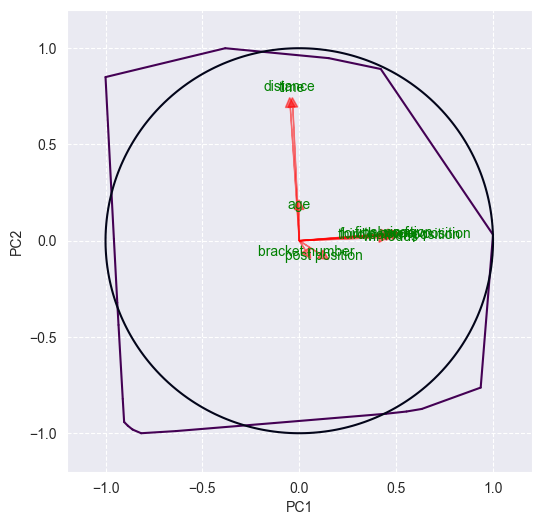

In [36]:
biplot(score=pca_res[:,0:2],
coeff=np.transpose(pca.components_[0:2,:]),
cat=y1[0:1], density=False, coeff_labels = list(
        [
            "distance",
            "final position",
            "bracket number",
            "post position",
            "age",
            "third corner position",
            "fourth corner position",
            "win odds",
            "win fav",
            "time"
        ]))
plt.show()

### 5.6 Visualisation des individus avec le plan factoriel

Projetez les individus sur le plan des deux premières composantes principales.

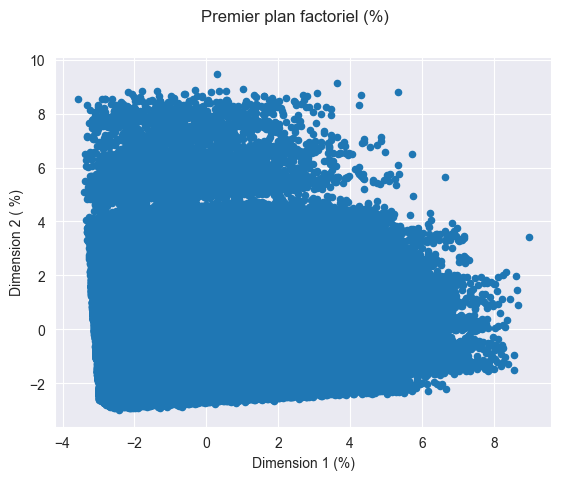

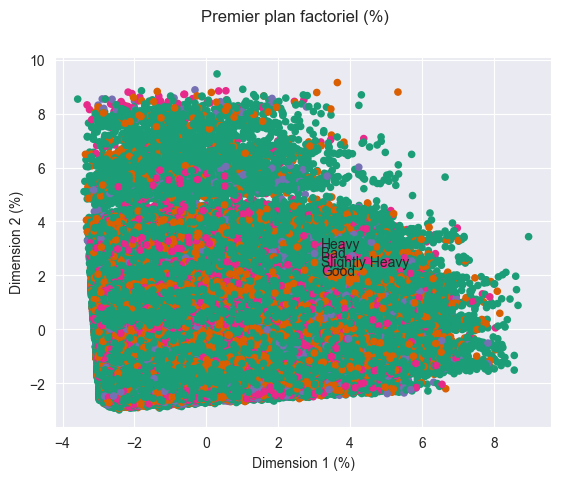

In [20]:
pca_df = pd.DataFrame ({
    "Dim1" : pca_res[:, 0],
    "Dim2" : pca_res[:, 1],
    "TDC" : df["Track Condition1"]
})
pca_df.plot.scatter("Dim1", "Dim2")
plt.xlabel("Dimension 1 (%)")
plt.ylabel("Dimension 2 ( %)")
plt.suptitle("Premier plan factoriel (%)")
plt.show()

palette = plt.get_cmap("Dark2")
couleurs = dict(zip(pca_df["TDC"].drop_duplicates(), palette(range(10))))
position=dict(zip(couleurs.keys(), range(10)))

pca_df.plot.scatter(
    "Dim1",
    "Dim2",
    c = [couleurs[p] for p in pca_df["TDC"]])
for cont, coul in couleurs.items() :
    plt.scatter(3, position[cont] / 3 + 2.15, c = [coul], s = 20)
    plt.text(3.2, position[cont] / 3 + 2, cont)
plt.xlabel("Dimension 1 (%)")
plt.ylabel("Dimension 2 (%)")
plt.suptitle("Premier plan factoriel (%)")
plt.show()

---

## 6. Variables qualitatives : AFC

### 6.1 Choix de deux variables, tableau de contingence

Sélectionnez deux variables qualitatives et construisez leur tableau de contingence.

Je choisit les variables "Weather" (météo)", "Track Condition1". Pour analyser la relation entre les conditions météorologiques et l'état de la piste.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

# Charger les données
data = pd.read_csv('./clean_datasets/translated_race_result.csv')
# On garde les colonnes qui ne sont pas Weather et Track Condition1
data = data[['Weather', 'Track Condition1']]
data = data.dropna()
data = data.astype(str)

# Tableau de contingence
contingency_table = pd.crosstab(data['Weather'], data['Track Condition1'])
print("Tableau de contingence entre Weather et Track Condition1:")
print(contingency_table)

Tableau de contingence entre Weather et Track Condition1:
Track Condition1    Bad    Good  Heavy  Slightly Heavy
Weather                                               
Clear                16      21      0               0
Clear Sky         16080  777420  52203           96163
Cloudy            32916  299726  49105           80919
Light Rain         8020   25520   8021           13511
Light Snow            9     683     41             499
Rain              28278   21666  17161           24619
Snow                341     736    143             329


### 6.2 Test de sphéricité de Bartlett/Test de Chi2, conclusion sur la corrélation

Effectuez le test du Chi2 sur le tableau de contingence et concluez sur la corrélation.

In [ ]:
print(contingency_table)

Track Condition1    Bad    Good  Heavy  Slightly Heavy
Weather                                               
Clear                16      21      0               0
Clear Sky         16080  777420  52203           96163
Cloudy            32916  299726  49105           80919
Light Rain         8020   25520   8021           13511
Light Snow            9     683     41             499
Rain              28278   21666  17161           24619
Snow                341     736    143             329


### 6.3 Standardisation

Expliquez la standardisation pour l'AFC/AMC si nécessaire.

### 6.4 Entraînement du modèle FactorAnalyzer

Entraînez un modèle FactorAnalyzer sur les données qualitatives.

### 6.5 ScreePlot pour les valeurs propres de facteurs

Affichez le scree plot des valeurs propres.


### 6.6 Graphiques sur 3 rotations différentes

Visualisez les résultats de l'analyse factorielle avec trois types de rotations différentes (ex : varimax, quartimax, equamax).

---

## 7. Conclusion